In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import networkx as nx

In [2]:
train = pd.read_csv('train_df.csv')
test = pd.read_csv('test_df.csv')
train_data = train.copy()
test_data = test.copy()

In [3]:
X_train = train_data.drop(columns=["search_id", "target"])
y_train = train_data["target"]

X_test = test_data.drop(columns=["search_id", "target"])
y_test = test_data["target"]

In [4]:
a = list(X_train.columns)
c = []
for i in a:
    if len(X_train[i].unique()) == 1:
        c.append(i)
        print(i)

feature_0
feature_73
feature_74
feature_75


In [5]:
a = list(X_test.columns)
c = []
for i in a:
    if len(X_test[i].unique()) == 1:
        c.append(i)
        print(i)

feature_0
feature_73
feature_74
feature_75


Как видим, есть таблицы с пустыми значениями, надо их удалить

In [6]:
X_train = X_train.drop(columns=c)
X_test = X_test.drop(columns=c)

In [7]:
X_train

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_76,feature_77,feature_78
0,0,0,1,20,3,40,0,3,1,0,...,0.054861,0.433005,0.188131,0.0734,0.204682,0.271755,0.055623,0.38648,0.0,0.0
1,0,0,1,20,3,40,0,3,0,0,...,0.853441,0.290734,0.048554,0.0382,0.195531,0.188787,0.036914,0.10982,0.0,0.0
2,0,0,1,20,3,40,0,3,1,0,...,0.857800,0.287074,0.045502,0.1510,0.148609,0.186517,0.027718,0.03674,0.0,0.0
3,0,0,1,20,3,40,0,3,1,1,...,0.000000,0.469645,0.145031,0.0699,0.223748,0.229039,0.051247,0.00000,0.0,0.0
4,0,0,1,20,3,40,0,3,1,1,...,0.000000,0.200816,0.061071,0.0382,0.170935,0.249031,0.042568,0.00000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15076,0,0,0,9,4,38,6,6,1,1,...,0.246707,0.683106,0.852841,0.0661,0.309672,0.921060,0.285226,0.98807,0.0,0.0
15077,0,0,0,9,4,38,6,6,1,0,...,0.800668,0.755745,0.658246,0.1899,0.303805,0.995086,0.302312,0.87146,0.0,0.0
15078,0,0,0,9,4,38,6,6,0,1,...,0.001164,0.583024,0.763281,0.0664,0.346538,0.993070,0.344137,0.49999,0.0,0.0
15079,0,0,0,9,4,38,6,6,1,1,...,0.821496,0.664485,0.893621,0.1899,0.243154,0.994833,0.241898,0.67614,0.0,0.0


Проведем отбор признаков

1)Ручной отбор

In [8]:
X_train_hand = X_train.copy()
X_test_hand = X_test.copy()

Посмотрим на матрицу корреляций по модулю больше 0.75:

In [9]:
def corr(df):
    #матрица корреляций
    correlation_matrix = df.corr()
    high_corr = correlation_matrix[abs(correlation_matrix) > 0.75]
    plt.figure(figsize=(16, 14))
    sns.heatmap(high_corr, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Correlation Matrix")
    return plt.show()
    
def table_corr(df):        
    #табличный формат
    correlation_matrix = df.corr()
    high_corr = correlation_matrix[abs(correlation_matrix) > 0.75]
    high_corr_tidy = high_corr.stack().reset_index()
    high_corr_tidy = high_corr_tidy[high_corr_tidy['level_0'] != high_corr_tidy['level_1']]
    high_corr_tidy = high_corr_tidy.drop_duplicates(subset=[0])
    high_corr_tidy.reset_index(drop=True, inplace=True)
    return high_corr_tidy

def graph(df):
    #граф
    a = table_corr(df)
    G = nx.from_pandas_edgelist(a, source='level_0', target='level_1', create_using=nx.Graph())
    plt.figure(figsize=(20, 15))
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=200, font_size=12, width=1.0)
    plt.title("Graph")
    plt.show()

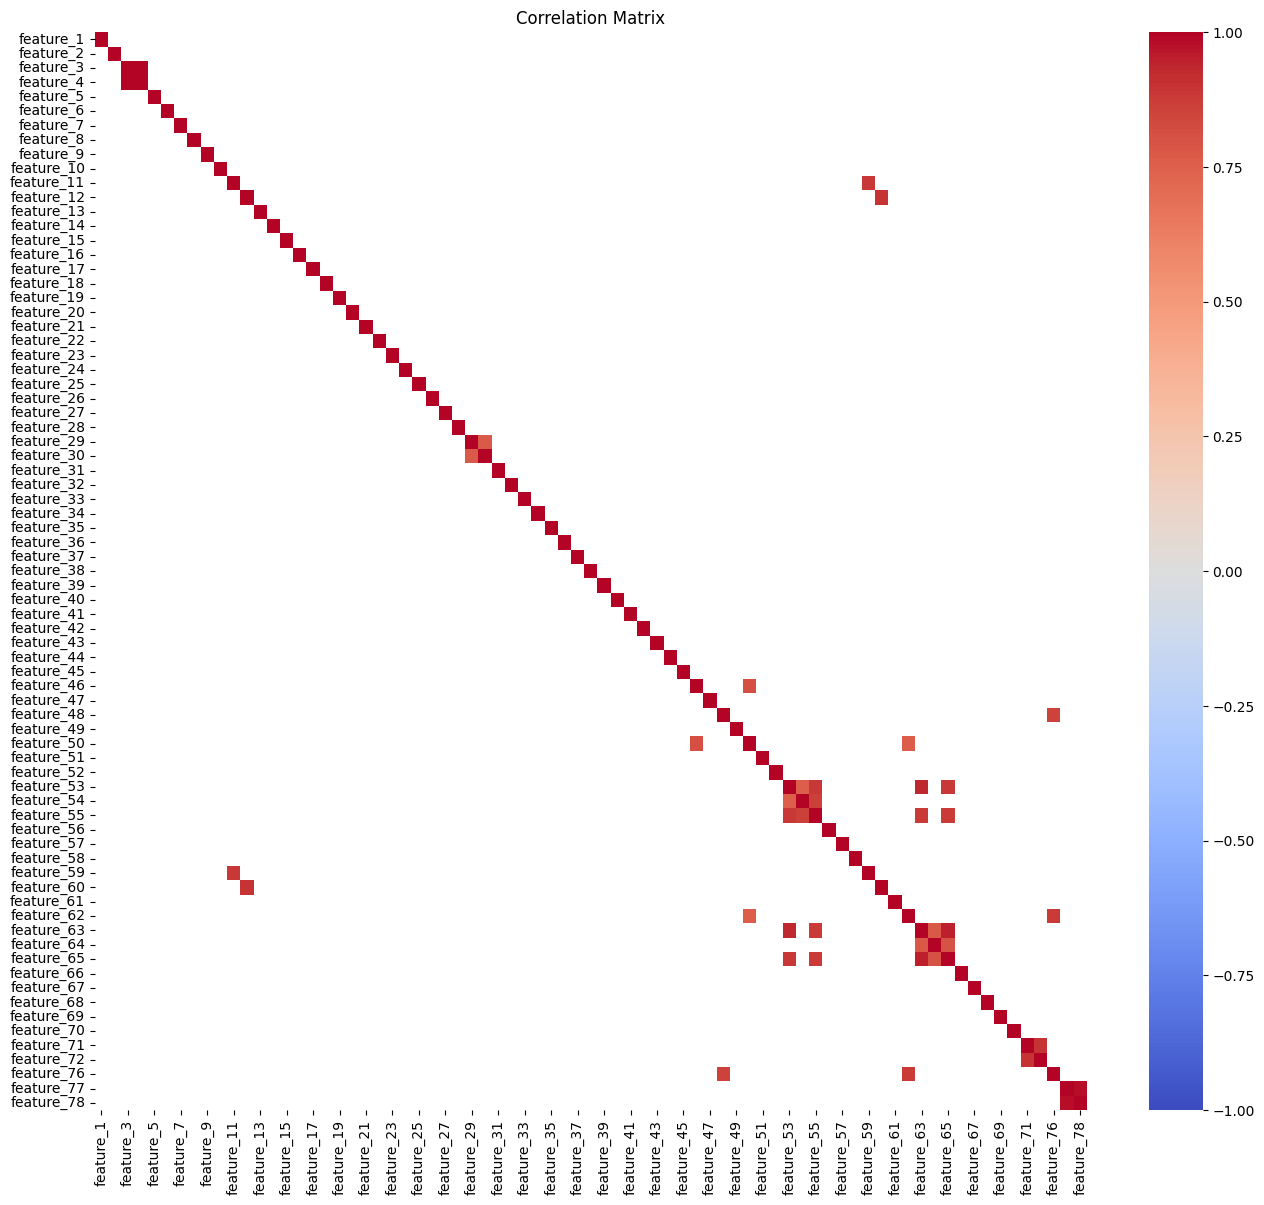

In [10]:
corr(X_test_hand)

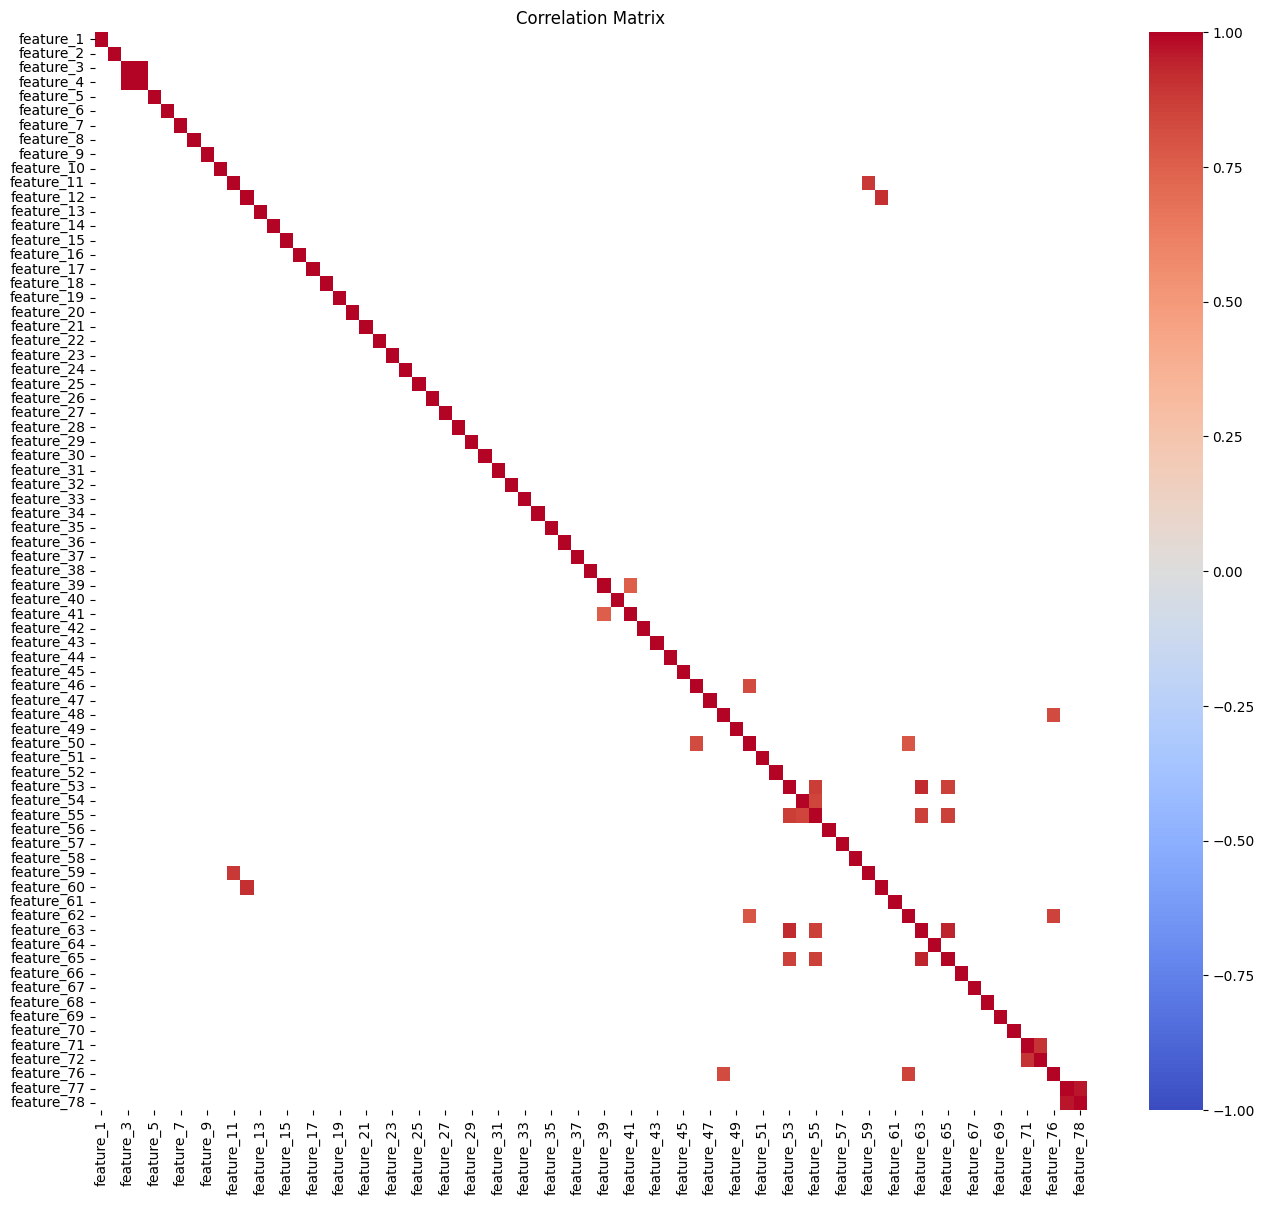

In [11]:
corr(X_train_hand)

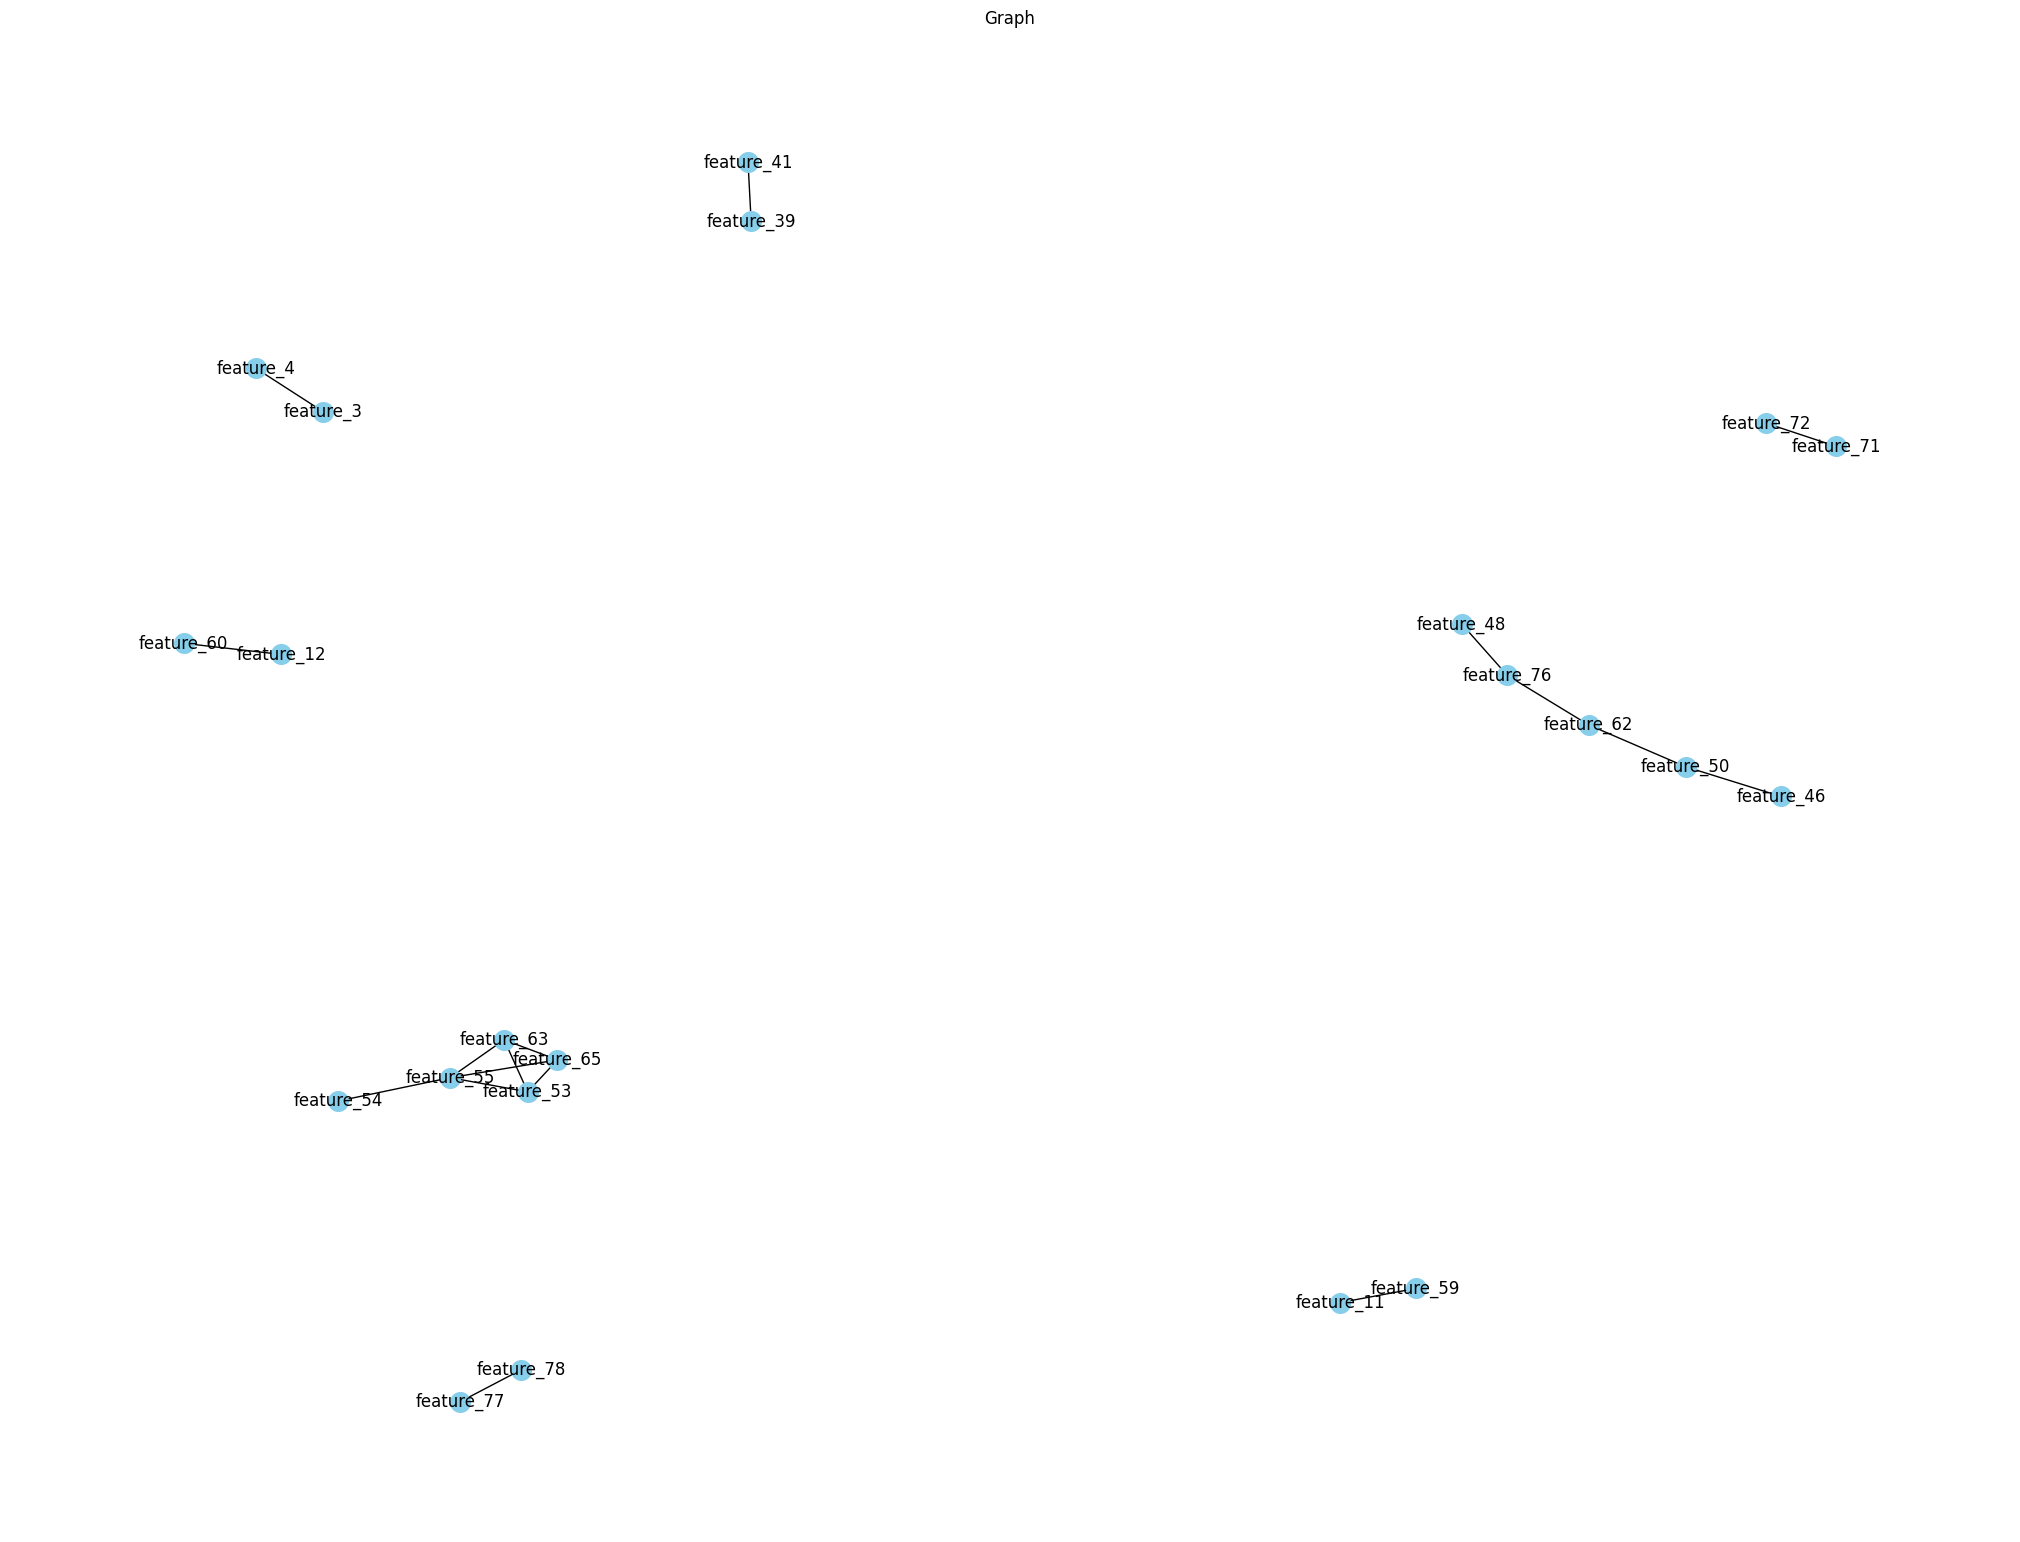

In [12]:
graph(X_train_hand)

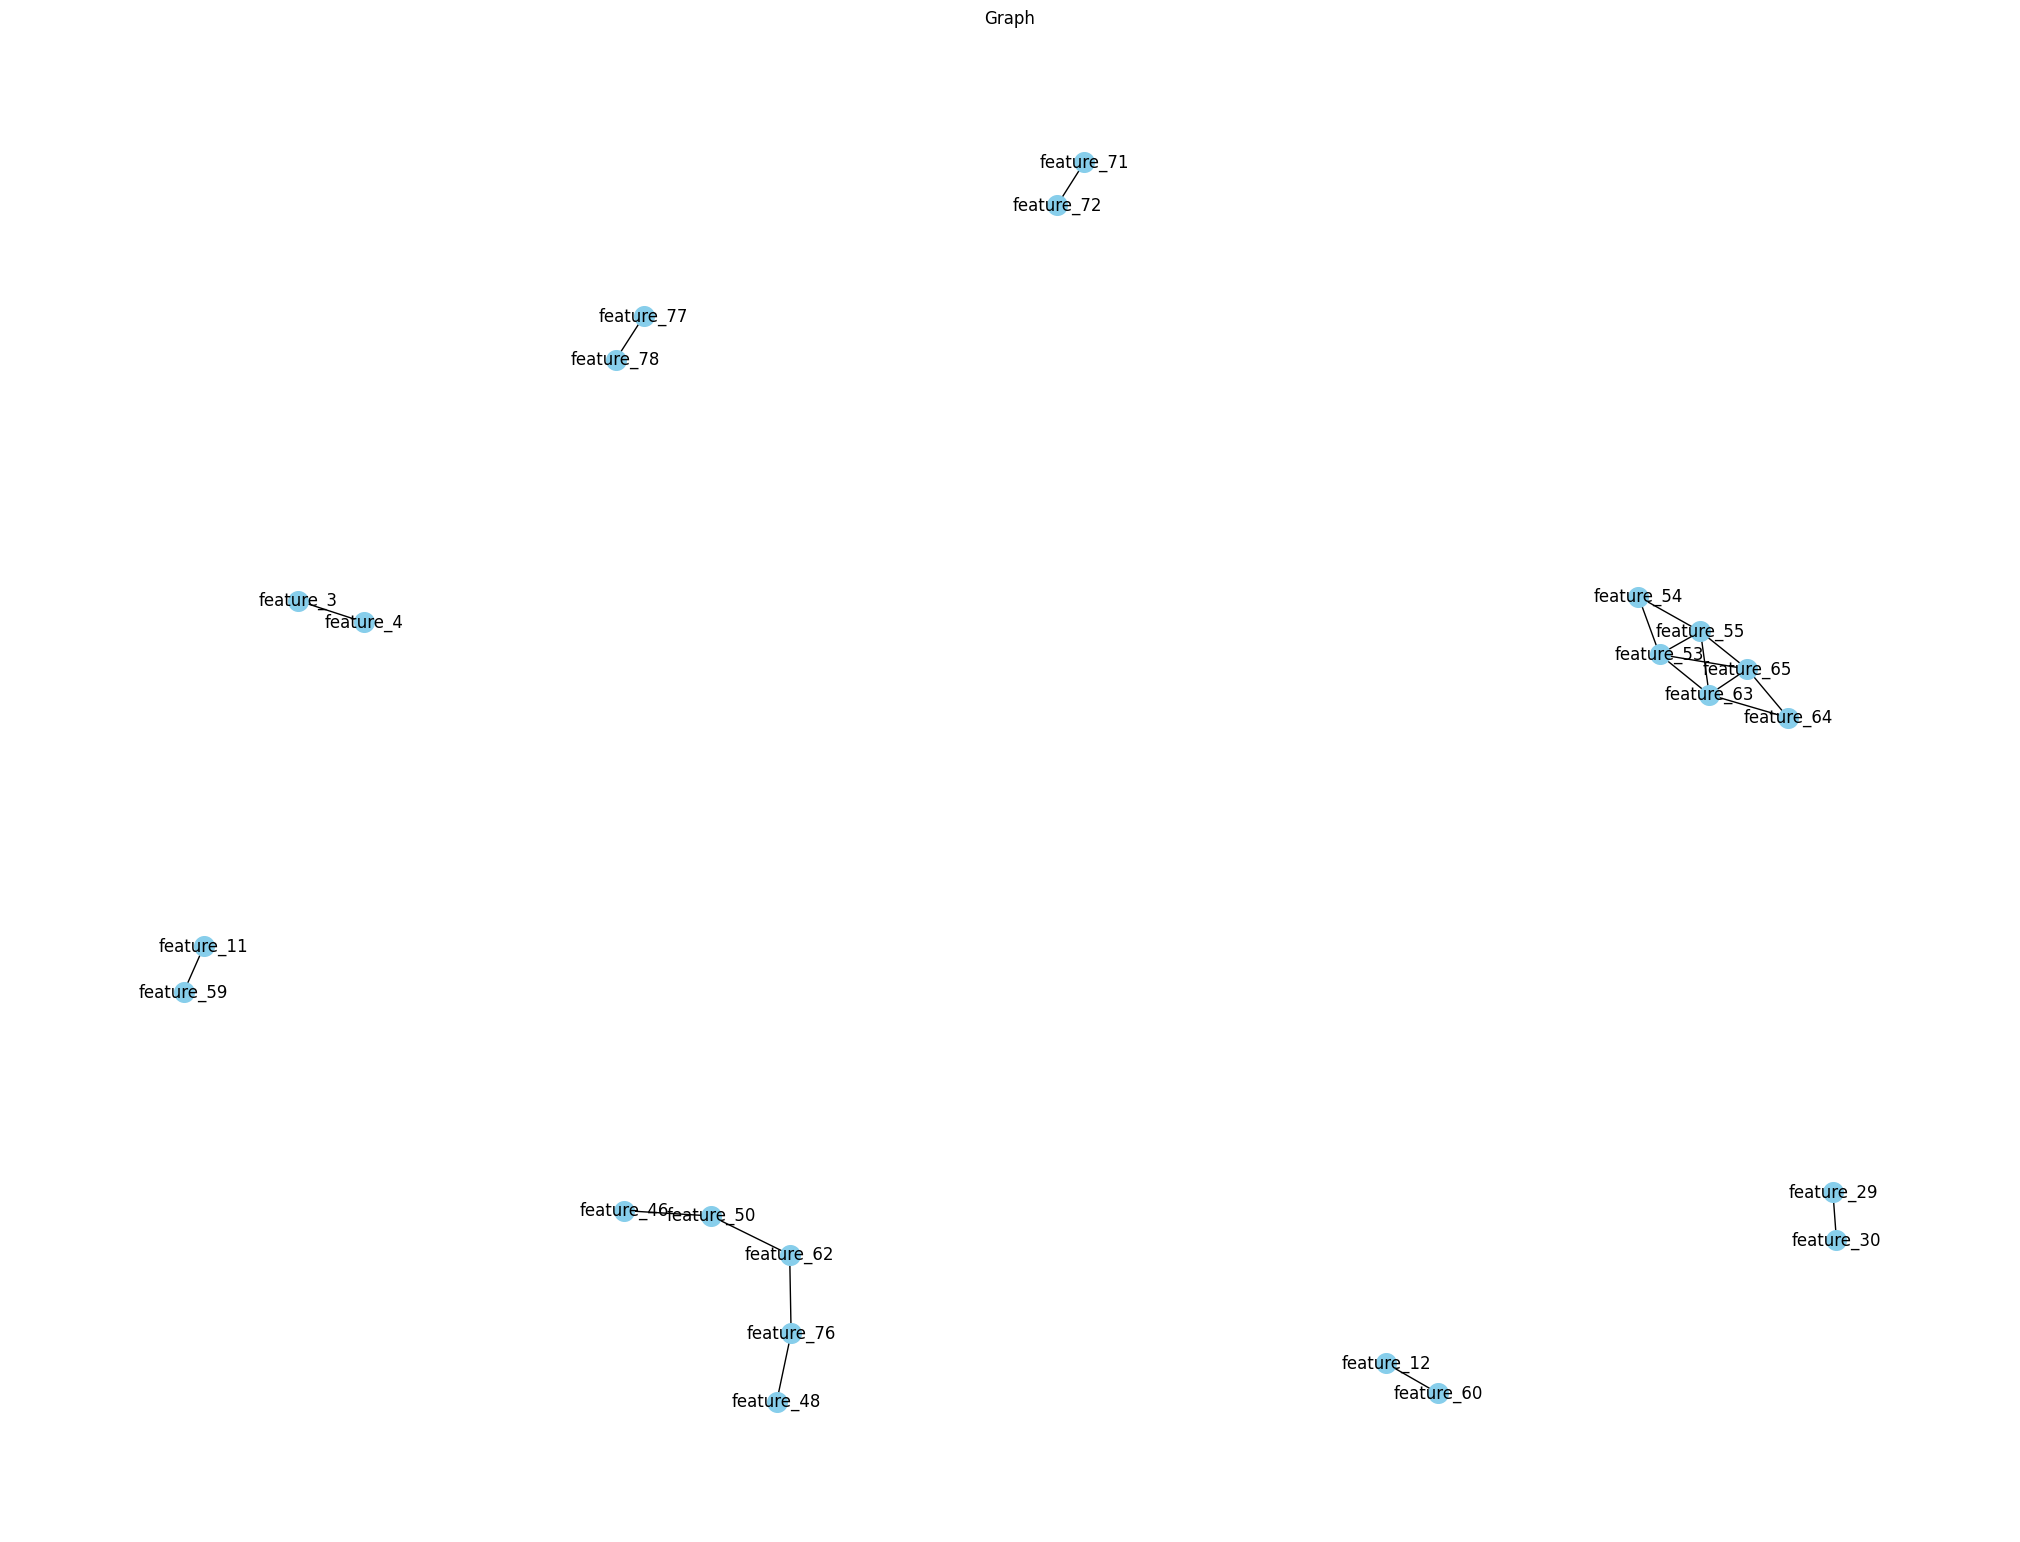

In [13]:
graph(X_test_hand)

В ручную удалим признаки и посмотрим на результат

In [14]:
arr = [71,11,77,29,39,3,12,76,50,65,53,55,63]

for i in arr:
    X_train_hand = X_train_hand.drop('feature_' + str(i), axis=1)
    X_test_hand = X_test_hand.drop('feature_' + str(i), axis=1)

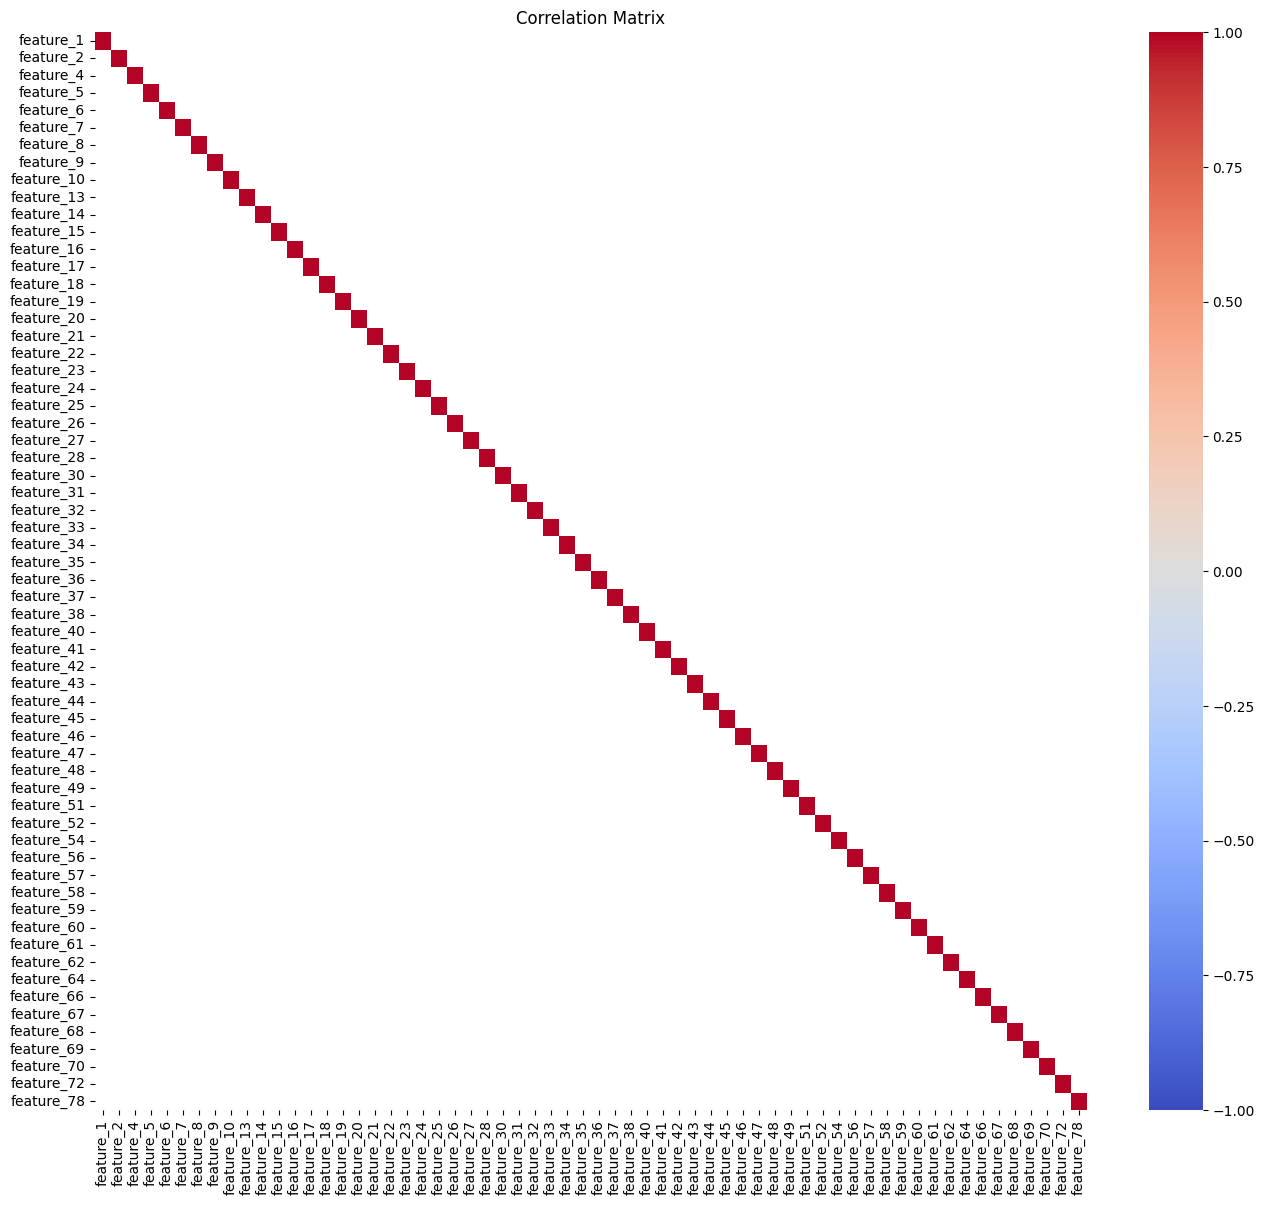

In [15]:
corr(X_test_hand)

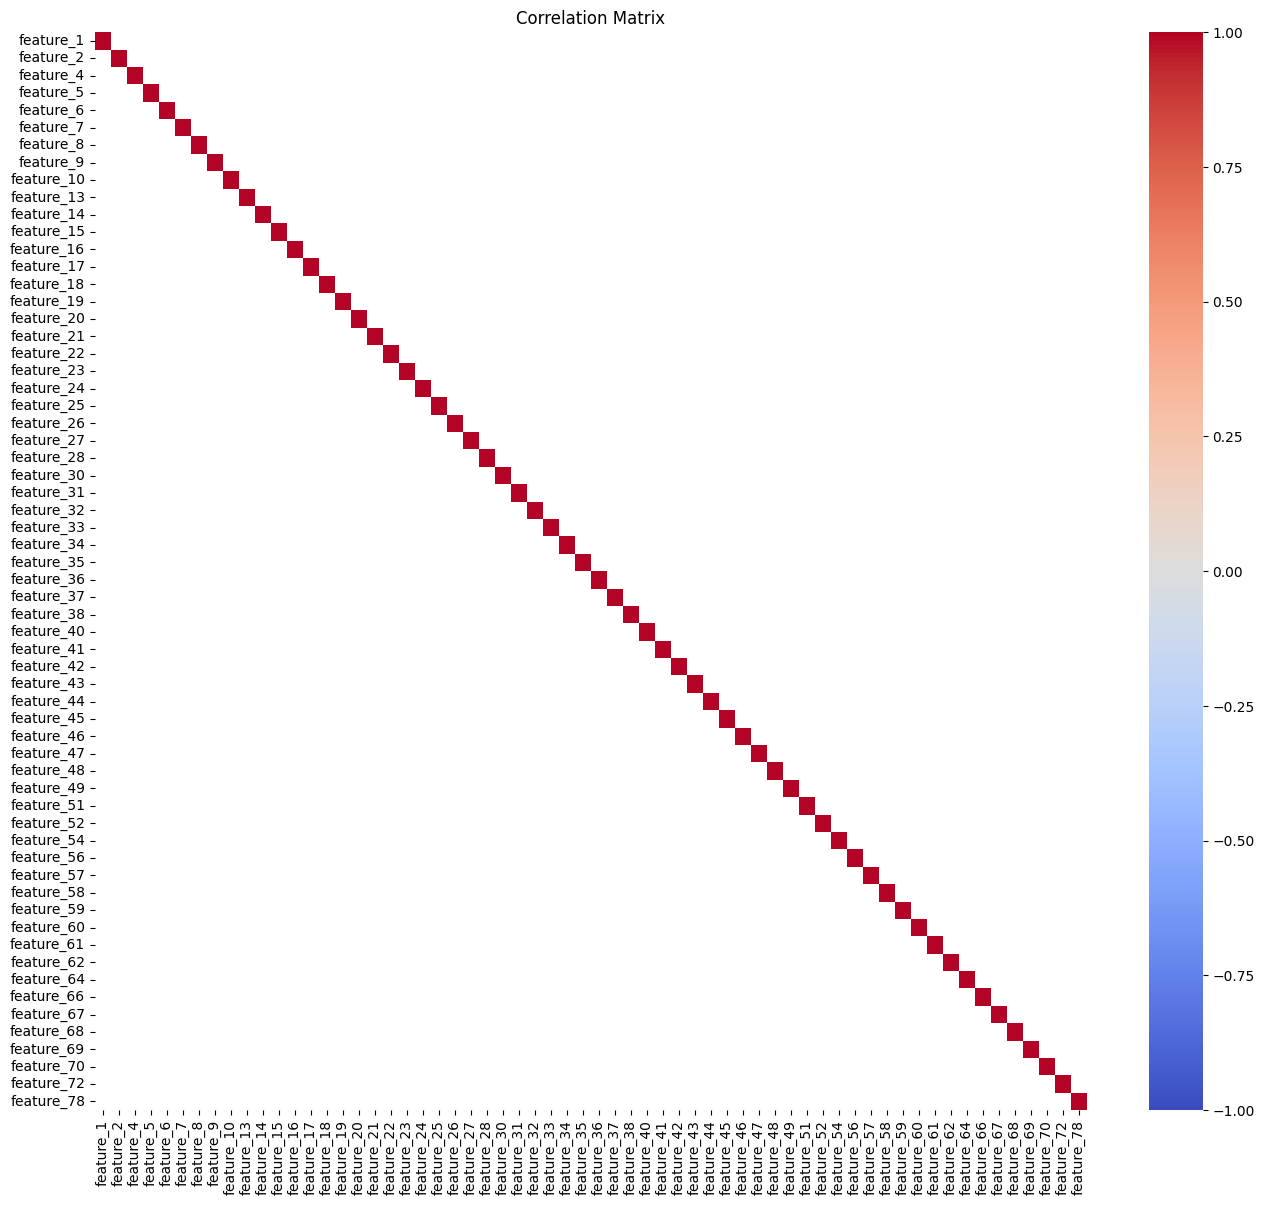

In [16]:
corr(X_train_hand)

Импортируем список моделей для тестов

In [17]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

def get_models():
    models = {
        'xgb': XGBRegressor(),
        'lr': LinearRegression(),
        'decision':DecisionTreeRegressor(),
        'random':RandomForestRegressor(n_estimators=100),
        'grad': GradientBoostingRegressor(),
        'adaboost': AdaBoostRegressor(),
        'knn': KNeighborsRegressor(),
        'svr':SVR(kernel='linear'),
        'ridge':Ridge(alpha=0.1),
        'lasso':Lasso(alpha=0.1),
        'elnet':ElasticNet(alpha=0.1, l1_ratio=0.5)
    }
    return models

Существует множество способов отбора признаков. Воспользуемся методом PCA.

Преимущество PCA заключается в том, что он позволяет снизить размерность данных, сохраняя при этом наибольшее количество информации.

Однако стоит помнить, что PCA не всегда сохраняет интерпретируемость признаков, так как новые признаки являются линейной комбинацией исходных.

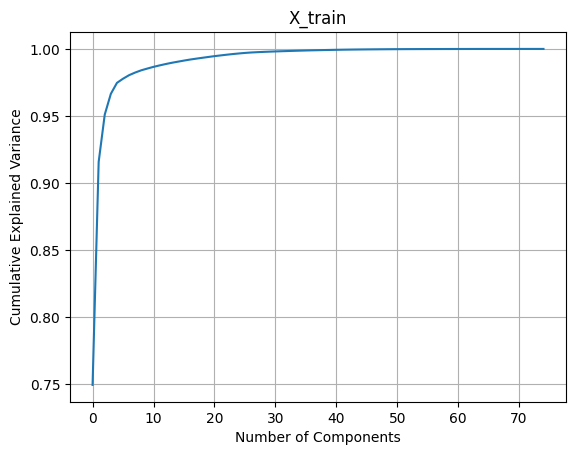

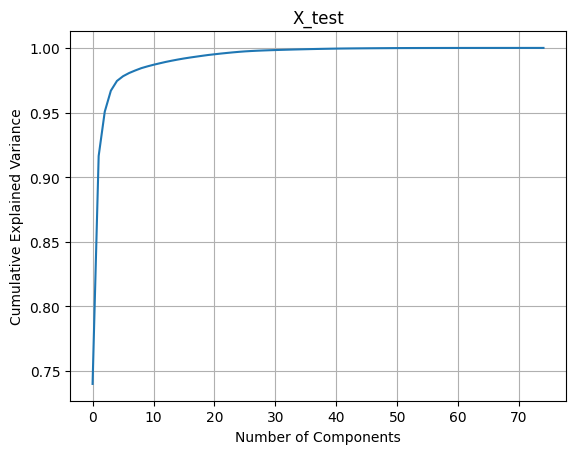

In [18]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.title("X_train")
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()
pca.fit(X_test)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.title("X_test")
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

Как мы видим, больше 40 признаков не дает существенного прироста на обоих датасетах.

In [19]:
pca = PCA(n_components=40)

X_pca_train = pca.fit_transform(X_train)
df_pca_train = pd.DataFrame(data=X_pca_train, columns=[f'PC{i}' for i in range(1, 41)])

X_pca_test = pca.fit_transform(X_test)
df_pca_test = pd.DataFrame(data=X_pca_test, columns=[f'PC{i}' for i in range(1, 41)])


Результат для "начальной выборки"

In [20]:
models = get_models()
for name, model in models.items():
    print(name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    ndcg = ndcg_score(y_test.values.reshape(1, -1), y_pred.reshape(1, -1))
    print(f"NDCG на тестовой выборке: {ndcg:.4f}")

xgb
NDCG на тестовой выборке: 0.4659
lr
NDCG на тестовой выборке: 0.5997
decision
NDCG на тестовой выборке: 0.4514
random
NDCG на тестовой выборке: 0.4857
grad
NDCG на тестовой выборке: 0.6209
adaboost
NDCG на тестовой выборке: 0.5745
knn
NDCG на тестовой выборке: 0.3752
svr
NDCG на тестовой выборке: 0.4562
ridge
NDCG на тестовой выборке: 0.5945
lasso
NDCG на тестовой выборке: 0.3899
elnet
NDCG на тестовой выборке: 0.3899


Результат для выборки "очищенной" вручную

In [21]:
models = get_models()
for name, model in models.items():
    print(name)
    model.fit(X_train_hand, y_train)
    y_pred = model.predict(X_test_hand)
    ndcg = ndcg_score(y_test.values.reshape(1, -1), y_pred.reshape(1, -1))
    print(f"NDCG на тестовой выборке: {ndcg:.4f}")

xgb
NDCG на тестовой выборке: 0.5632
lr
NDCG на тестовой выборке: 0.5616
decision
NDCG на тестовой выборке: 0.4531
random
NDCG на тестовой выборке: 0.5021
grad
NDCG на тестовой выборке: 0.5634
adaboost
NDCG на тестовой выборке: 0.4423
knn
NDCG на тестовой выборке: 0.3990
svr
NDCG на тестовой выборке: 0.4206
ridge
NDCG на тестовой выборке: 0.5550
lasso
NDCG на тестовой выборке: 0.3899
elnet
NDCG на тестовой выборке: 0.3899


Результат для выборки "очищенной" методом PCA

In [22]:
models = get_models()
for name, model in models.items():
    print(name)
    model.fit(df_pca_train, y_train)
    y_pred = model.predict(df_pca_test)
    ndcg = ndcg_score(y_test.values.reshape(1, -1), y_pred.reshape(1, -1))
    print(f"NDCG на тестовой выборке: {ndcg:.4f}")

xgb
NDCG на тестовой выборке: 0.3850
lr
NDCG на тестовой выборке: 0.3708
decision
NDCG на тестовой выборке: 0.3852
random
NDCG на тестовой выборке: 0.3666
grad
NDCG на тестовой выборке: 0.3640
adaboost
NDCG на тестовой выборке: 0.3734
knn
NDCG на тестовой выборке: 0.3728
svr
NDCG на тестовой выборке: 0.3658
ridge
NDCG на тестовой выборке: 0.3708
lasso
NDCG на тестовой выборке: 0.3899
elnet
NDCG на тестовой выборке: 0.3899


Результат для выборки "очищенной" методом SelectKBest

In [23]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score

mse_scores = []

for k in range(1, 76):
    k_best = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = k_best.fit_transform(X_train, y_train)
    mse_score = -cross_val_score(LinearRegression(), X_train_selected, y_train, scoring='neg_mean_squared_error', cv=5).mean()
    mse_scores.append(mse_score)

optimal_k = np.argmin(mse_scores) + 1
print("Optimal k:", optimal_k)

k_best = SelectKBest(score_func=f_regression, k=optimal_k)
X_train_selectKBest = k_best.fit_transform(X_train, y_train)
X_test_selectKBest = k_best.transform(X_test)


Optimal k: 25


In [24]:
models = get_models()
for name, model in models.items():
    print(name)
    model.fit(X_train_selectKBest, y_train)
    y_pred = model.predict(X_test_selectKBest)
    ndcg = ndcg_score(y_test.values.reshape(1, -1), y_pred.reshape(1, -1))
    print(f"NDCG на тестовой выборке: {ndcg:.4f}")

xgb
NDCG на тестовой выборке: 0.4592
lr
NDCG на тестовой выборке: 0.6217
decision
NDCG на тестовой выборке: 0.4201
random
NDCG на тестовой выборке: 0.4723
grad
NDCG на тестовой выборке: 0.5175
adaboost
NDCG на тестовой выборке: 0.4620
knn
NDCG на тестовой выборке: 0.3805
svr
NDCG на тестовой выборке: 0.5100
ridge
NDCG на тестовой выборке: 0.6235
lasso
NDCG на тестовой выборке: 0.3899
elnet
NDCG на тестовой выборке: 0.3899


Сделаем сводную таблицу

In [25]:
train_dfs = [X_train, X_train_hand, df_pca_train, X_train_selectKBest]
test_dfs = [X_test, X_test_hand, df_pca_test, X_test_selectKBest]

def apply_models_and_combine(models, train_dfs, test_dfs):
    results = []

    for train_df, test_df in zip(train_dfs, test_dfs):
        model_results = {}
        for name, model in models.items():
            model.fit(train_df, y_train)
            y_pred = model.predict(test_df)
            ndcg = ndcg_score(y_test.values.reshape(1, -1), y_pred.reshape(1, -1))
            model_results[name] = round(ndcg,4)
        results.append(model_results)
        
    names = ['X','hand','pca','selectKBest']
    results_df = pd.DataFrame(results, index=[name for name in names])

    return results_df

results_df = apply_models_and_combine(models, train_dfs, test_dfs)
print(results_df)


                xgb      lr  decision  random    grad  adaboost     knn  \
X            0.4659  0.5997    0.4396  0.4916  0.6192    0.4545  0.3752   
hand         0.5632  0.5616    0.4703  0.4690  0.5859    0.5125  0.3990   
pca          0.3850  0.3708    0.3655  0.3654  0.3703    0.3752  0.3728   
selectKBest  0.4592  0.6217    0.4364  0.5023  0.5242    0.5680  0.3805   

                svr   ridge   lasso   elnet  
X            0.4562  0.5945  0.3899  0.3899  
hand         0.4206  0.5550  0.3899  0.3899  
pca          0.3658  0.3708  0.3899  0.3899  
selectKBest  0.5100  0.6235  0.3899  0.3899  


In [26]:
results_df

,xgb,lr,decision,random,grad,adaboost,knn,svr,ridge,lasso,elnet
X,0.4659,0.5997,0.4396,0.4916,0.6192,0.4545,0.3752,0.4562,0.5945,0.3899,0.3899
hand,0.5632,0.5616,0.4703,0.4690,0.5859,0.5125,0.3990,0.4206,0.5550,0.3899,0.3899
pca,0.3850,0.3708,0.3655,0.3654,0.3703,0.3752,0.3728,0.3658,0.3708,0.3899,0.3899
selectKBest,0.4592,0.6217,0.4364,0.5023,0.5242,0.5680,0.3805,0.5100,0.6235,0.3899,0.3899


По сводной таблице видно, что лучшй результат показывают (selectKBest, lr), (selectKBest, ridge), а так же (X, grad)